# Summary
*Note: In all cases, the number of notifications is per month, and the percentages are out of the total number of users who received any notifications, or the total number of notifications received.*

The distribution of notifications seems largely to follow a long-tailed [power law](https://en.wikipedia.org/wiki/Power_law) distribution. Almost all users receive very few (about 94% get from 1 to 4), while a very small number of highly-active users account for a large number of notifications (with 1-2% of users receiving 25 or more per month, and about 0.1% receiving 10-15% of the total notifications). 

The wikis I studied fell into three main groups:
* English Wikipedia and Japanese Wikipedia, which I expect represent "normal" large wikis. 
* Commons, where the number of highly-notified users is particularly small (98.5% of users receive 1 to 4 notifications, and 0.1% receive 25 or more). 
* French Wikipedia and Chinese Wikipedia, where Flow is used heavily. Both these wikis have a somewhat larger proportion of users with many notifications, largely because of substantial bump in the proportion of users with who get 20–30 notifications per month.

I would suggest the following conclusions based on this data:
* It is not worth investing significant resources into notification management tools (other than better bundling) until Flow or similar products are rolled out to more wikis.
* It may be worth investigating the small subset of users who receive a very high number of notifications to learn more about their habits. For example, they may be bots, or as highly-active users they may feel that they badly need better notification management.

# Setup and data collection

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax

The data was generated from the [Echo extension's](https://www.mediawiki.org/wiki/Notifications) database tables for the following wikis:
* Commons (commonswiki)
* English Wikipedia (enwiki)
* Japanese Wikipedia (jawiki), 
* French Wikipedia (frwiki)
* Chinese Wikipedia (zhwiki). 

I chose frwiki and zhwiki because they are relatively heavy users (frwiki at its central discussion board and zhwiki on user talk pages) of [Flow](https://www.mediawiki.org/wiki/Flow), which generates a large number of notifications when it's used for discussions.

The raw queries were the following:

**Total notifications**
```
SELECT 
	DATABASE() as "wiki",
	`notifications`,
	 COUNT(*) as "users"
FROM
(
	SELECT
		COUNT(*) as "total notifications",
	FROM echo_notification
	WHERE
		notification_timestamp > "20160111" AND
		notification_timestamp < "20160210"
	GROUP BY notification_user
) notifications_by_user
GROUP BY `total notifications`;
```

**Unread notifications**
```
SELECT
	DATABASE() as "wiki",
	`unread notifications`,
	 COUNT(*) as "users"
FROM
(
	SELECT
		SUM( IF( notification_read_timestamp IS NULL, 1, 0) ) as "unread notifications"
	FROM echo_notification
	WHERE
		notification_timestamp > "20160111" AND
		notification_timestamp < "20160210"
	GROUP BY notification_user
) notifications_by_user
GROUP BY `unread notifications`;
```
I ran them through [multiquery](https://github.com/halfak/multiquery) using the following command:
```
$ multiquery {{sql file}} --dbnames=notifications_dbs.tsv --host=x1-analytics-slave.eqiad.wmnet --defaults-file=~/.my.cnf > {{output file}}
```

I ran the unread query on 17 March, so the unread counts reflect notifications from the month which were still unread 34 days after it ended. Therefore, those counts likely reflect notifications which can be considered permanently unread.

In [3]:
notifs = pd.read_table("./notifications_per_user.tsv")
unreads = pd.read_table("./unread_notifications_per_user.tsv")
wikis = set(notifs["wiki"])

notifs.tail()

,wiki,total notifications,users
697,zhwiki,272,1
698,zhwiki,291,1
699,zhwiki,320,1
700,zhwiki,403,1
701,zhwiki,452,1


In [4]:
def filter_by_wiki( df, wiki ):
    return df[ df["wiki"] == wiki ].iloc[:, 1:3]

def plot_by_wiki( df, wiki, range = (5, 104), bins = 20, ax = plt ): 
    dist = filter_by_wiki( df, wiki )
    ax.hist( dist.iloc[:, 0], bins = bins, range = range, weights = dist.iloc[:, 1])
    ax.set_title(wiki)
    ax.set_xlabel( "Number of notifications" )
    ax.set_ylabel( "Users" )

# Total notifications

This data covers all the users who received at least one notification during the month, whether they actually visited the site during month or not, so we'd expect that the numbers are dominated by a large bulk of users with very few notifications, and that there's a long tail of very few users with a very large number of notifications. 

But let's characterize that a bit. At each wiki, how many and what percent of users with any notifications got fewer than 5?

In [5]:
def beyond_threshold(df, wikis, threshold, direction):
    for wiki in wikis:
        by_wiki = filter_by_wiki(df, wiki)
        total_users = by_wiki.iloc[:, 1].sum()
        
        total_notifs = 0 
        for row in by_wiki.iterrows():
            total_notifs += row[1][0] * row[1][1]
        
        if direction == "under":
            beyond_threshold = by_wiki[ by_wiki.iloc[:, 0] < threshold ]
        elif direction == "over":
            beyond_threshold = by_wiki[ by_wiki.iloc[:, 0] > threshold ]
        
        users_beyond_threshold = beyond_threshold.iloc[:, 1].sum()
        notifs_beyond_threshold = 0
                
        for row in beyond_threshold.iterrows():
            notifs_beyond_threshold += row[1][0] * row[1][1]
        
        user_proportion = users_beyond_threshold / total_users
        notifs_proportion = notifs_beyond_threshold / total_notifs
        
        print(wiki + ":", str(users_beyond_threshold) + " users,",
            str(round(user_proportion * 100, 1)) + "% of total,",
            str(round(notifs_proportion * 100, 1)) + "% of notifications")

beyond_threshold( notifs, wikis, 5, "under")

enwiki: 221540 users, 94.6% of total, 54.5% of notifications
commonswiki: 106509 users, 98.5% of total, 85.3% of notifications
frwiki: 30657 users, 93.1% of total, 44.0% of notifications
zhwiki: 8641 users, 90.6% of total, 31.0% of notifications
jawiki: 8768 users, 93.6% of total, 55.9% of notifications


And what percent of users got 25 notifications or more?

In [6]:
beyond_threshold(notifs, wikis, 24, "over")  

enwiki: 1837 users, 0.8% of total, 27.3% of notifications
commonswiki: 135 users, 0.1% of total, 6.6% of notifications
frwiki: 696 users, 2.1% of total, 41.3% of notifications
zhwiki: 200 users, 2.1% of total, 38.7% of notifications
jawiki: 86 users, 0.9% of total, 23.8% of notifications


That's lower than I expected at English Wikipedia. It only had about 1800 users with at least 25 notifications per month, compared to 30,000 active and 3,500 highly active users per month. However, both Flow wikis have substantially higher percentages than the non-Flow wikis.

Now, let's look at the actual distributions. To make it easier to comprehend, I'll cut off the 90%+ of users with fewer than 5 notifications. I'll also cut off the users with more than 105. How many is that?

In [7]:
beyond_threshold(notifs, wikis, 105, "over")

enwiki: 318 users, 0.1% of total, 13.6% of notifications
commonswiki: 21 users, 0.0% of total, 2.8% of notifications
frwiki: 94 users, 0.3% of total, 19.5% of notifications
zhwiki: 19 users, 0.2% of total, 11.8% of notifications
jawiki: 10 users, 0.1% of total, 10.0% of notifications


Now for the graphs:

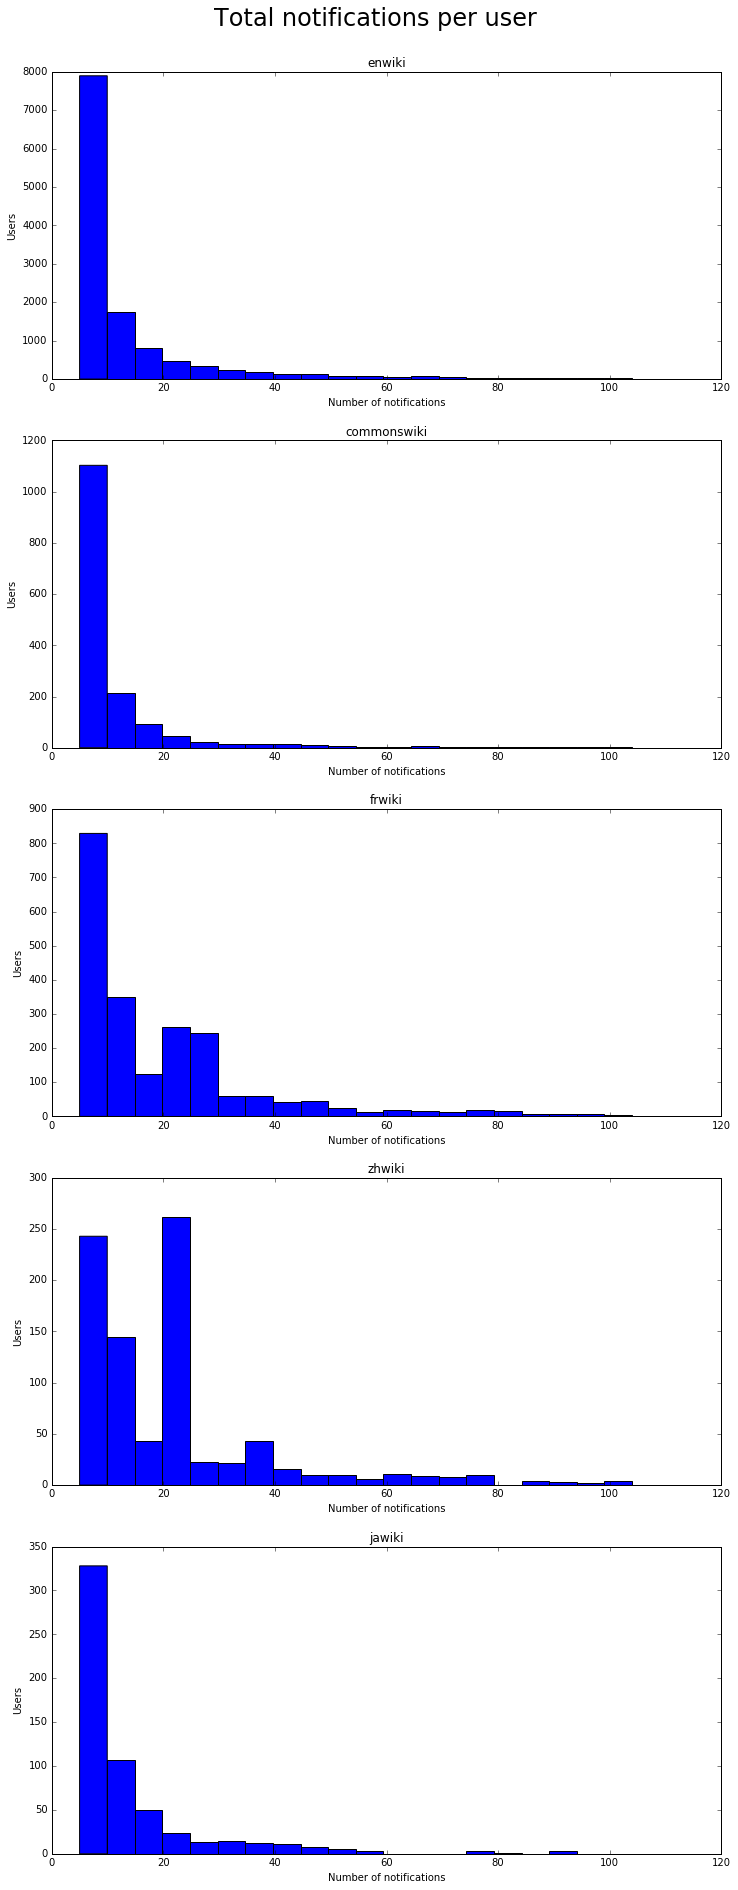

In [8]:
fig, axarr = plt.subplots( 5, 1, figsize=(12,30) )
fig.suptitle("Total notifications per user", fontsize=24)
fig.subplots_adjust(top=0.95)
i = 0
for wiki in wikis:
    plot_by_wiki(notifs, wiki, ax = axarr[i])
    i = i + 1

So, as expected, the non-Flow wikis have a pretty regular [power-law distribution](https://en.wikipedia.org/wiki/Power_law) of notifications. 

However, over this range that isn't true for the Flow-heavy wikis. Users with 21-25 notifications *substantially* outnumber users with 16-20. I discuss this below.

# Unread notifications

First, the counts and percentages for various levels of unread notifications.

Under 5:

In [9]:
beyond_threshold(unreads, wikis, 5, "under")

enwiki: 230737 users, 98.5% of total, 75.1% of notifications
commonswiki: 107285 users, 99.2% of total, 93.1% of notifications
frwiki: 31760 users, 96.5% of total, 51.2% of notifications
zhwiki: 8924 users, 93.6% of total, 26.0% of notifications
jawiki: 9169 users, 97.9% of total, 71.3% of notifications


25 or more:

In [10]:
beyond_threshold(unreads, wikis, 24, "over")

enwiki: 354 users, 0.2% of total, 12.7% of notifications
commonswiki: 25 users, 0.0% of total, 1.8% of notifications
frwiki: 358 users, 1.1% of total, 32.7% of notifications
zhwiki: 136 users, 1.4% of total, 34.9% of notifications
jawiki: 26 users, 0.3% of total, 13.8% of notifications


Over 105:

In [11]:
beyond_threshold(unreads, wikis, 105, "over")

enwiki: 49 users, 0.0% of total, 6.8% of notifications
commonswiki: 4 users, 0.0% of total, 1.0% of notifications
frwiki: 39 users, 0.1% of total, 15.3% of notifications
zhwiki: 2 users, 0.0% of total, 2.7% of notifications
jawiki: 2 users, 0.0% of total, 4.0% of notifications


Now, the graphs:

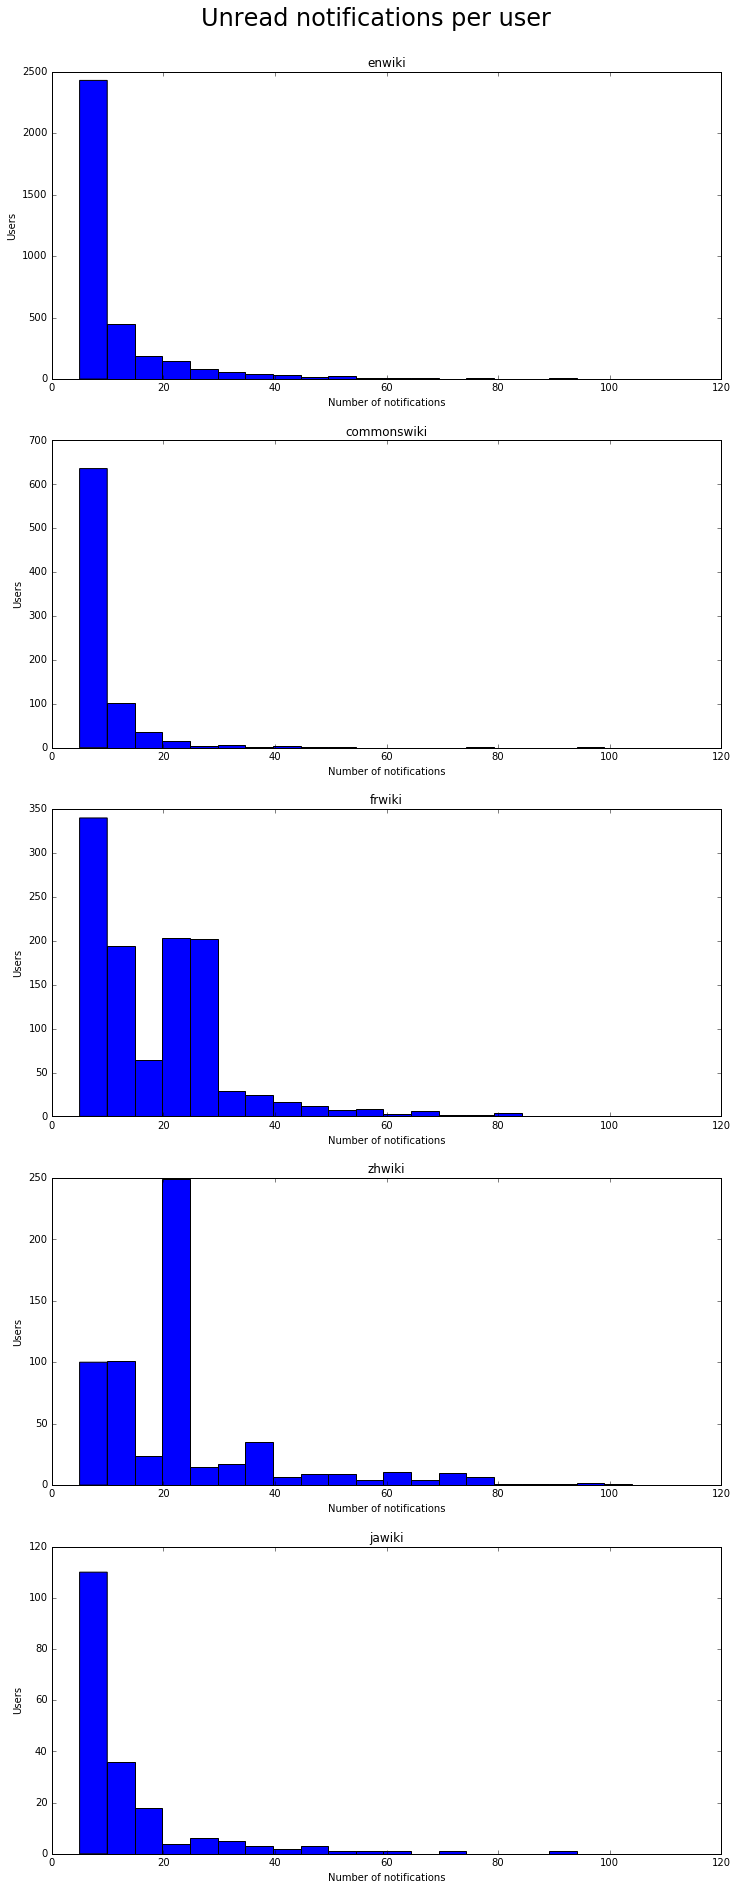

In [12]:
fig, axarr = plt.subplots( 5, 1, figsize=(12,30) )
fig.suptitle("Unread notifications per user", fontsize=24)
fig.subplots_adjust(top=0.95)
i = 0
for wiki in wikis:
    plot_by_wiki(unreads, wiki, ax = axarr[i])
    i = i + 1

This is a similar pattern as with total notifications, although the [bimodal](https://en.wikipedia.org/wiki/Multimodal_distribution) pattern at the Flow wikis seems even more pronounced.

# Peaks
So why do Flow-heavy wikis display secondary peaks in the distribution?

One possibility is they're a natural behavioral effect of Flow. For example, perhaps only a certain subset of users use Flow (whether because they've converted their talk page or because they're watching the Flow-enabled discussion forum), and that once you join this group, you're more likely to get, say, 20 notifications than 10.

Another possibility is that they're a software artifact. For example, perhaps some function somewhere treats all cases where a user has at least 25 notifications the same, and ends up actually writing "25" to the database in all such cases. 

Let me zoom in on those peaks.

In [36]:
zh = filter_by_wiki( notifs, "zhwiki" )
zh[ (zh["total notifications"] >= 15) & (zh["total notifications"] < 30) ]

,total notifications,users
617,15,11
618,16,7
619,17,14
620,18,6
621,19,5
622,20,7
623,21,5
624,22,7
625,23,230
626,24,13


In [38]:
fr = filter_by_wiki( notifs, "frwiki" )
fr[ (fr["total notifications"] >= 15) & (fr["total notifications"] < 30) ]

,total notifications,users
447,15,44
448,16,23
449,17,20
450,18,22
451,19,16
452,20,190
453,21,25
454,22,24
455,23,11
456,24,12


So these peaks seem to be "sharp" rather than "smooth", which suggests they're a software artifact rather than an underlying phenomenon. At frwiki, the peaks are at 20 and 25, which suggests the same thing since programmers are likely to place artificial cut-offs at round numbers. At zhwiki, the peak is at 23, which is much odder. However, a software artifact still seems the most likely explanation.